Epoch 1, Loss: 81.85920715332031
Epoch 101, Loss: 2.194812536239624
Epoch 201, Loss: 1.6986559629440308
Epoch 301, Loss: 1.8004486560821533
Epoch 401, Loss: 1.9115245342254639
Epoch 501, Loss: 1.3811947107315063
Epoch 601, Loss: 1.7475210428237915
Epoch 701, Loss: 1.6845420598983765
Epoch 801, Loss: 1.6634337902069092
Epoch 901, Loss: 1.4649217128753662


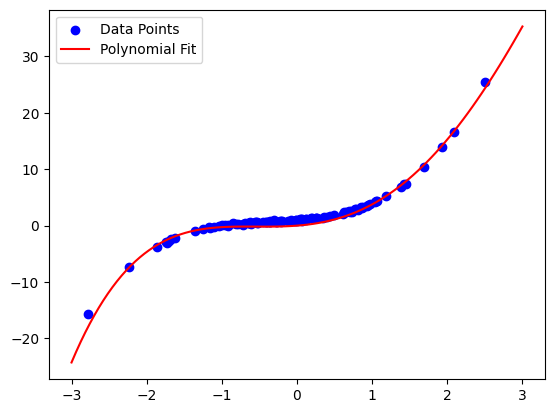

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchviz import make_dot

# 定义一个多项式函数
class PolynomialModel(nn.Module):
    def __init__(self, degree):
        super(PolynomialModel, self).__init__()
        self.degree = degree
        self.layers = nn.ModuleList([nn.Linear(1, 1, bias=False) for _ in range(degree + 1)])

    def forward(self, x):
        # 计算多项式
        out = torch.zeros_like(x)
        for i, layer in enumerate(self.layers):
            out += layer(x) * x**i
        return out

# 初始化模型
degree = 3  # 多项式的最高次数
model = PolynomialModel(degree)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 生成一些随机数据来模拟x和y的关系
x_data = torch.randn(100, 1)  # 生成100个随机样本
y_data = torch.cat([x_data**i for i in range(degree + 1)], 1).sum(1, keepdim=True)  # 计算y的理论值

# 添加随机噪声来模拟真实数据
y_data += torch.randn_like(y_data) * 0.1  # 假设噪声是均值为0，标准差为0.1的正态分布

# 训练模型
for epoch in range(1000):
    optimizer.zero_grad()
    # 生成随时间变化的随机变量 τ(t)
    tau = torch.randn_like(x_data)  # 假设 x_data 已经被定义，并且具有正确的时间维度
    
    # 计算模型的输出
    y_pred = model(x_data) + tau  # 将随机变量添加到模型的输出中
    loss = criterion(y_pred, y_data)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# 可视化模型
x_test = torch.linspace(-3, 3, 100).unsqueeze(1)  # 创建一个测试集
y_pred = model(x_test)

plt.scatter(x_data.numpy(), y_data.numpy(), color='blue', label='Data Points')
plt.plot(x_test.numpy(), y_pred.detach().numpy(), color='red', label='Polynomial Fit')
plt.legend()
plt.show()

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定义一个多项式函数
class PolynomialModel(nn.Module):
    def __init__(self, degree):
        super(PolynomialModel, self).__init__()
        self.degree = degree
        self.layers = nn.ModuleList([nn.Linear(1, 1, bias=False) for _ in range(degree + 1)])

    def forward(self, x):
        # 计算多项式
        out = torch.zeros_like(x)
        for i, layer in enumerate(self.layers):
            out += layer(x) * x**i
        return out

# 初始化模型
degree = 3  # 多项式的最高次数
model = PolynomialModel(degree)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 训练模型
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # 生成随时间变化的随机变量 τ(t)
    tau = torch.randn_like(x_data)  # 假设 x_data 已经被定义，并且具有正确的时间维度
    
    # 计算模型的输出
    y_pred = model(x_data) + tau  # 将随机变量添加到模型的输出中
    
    # 计算损失
    loss = criterion(y_pred, y_data)
    
    # 反向传播和优化
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 100, Loss: 1.6754399538040161
Epoch 200, Loss: 1.626210331916809
Epoch 300, Loss: 1.8653616905212402
Epoch 400, Loss: 1.9050227403640747
Epoch 500, Loss: 1.4701248407363892
Epoch 600, Loss: 1.7123156785964966
Epoch 700, Loss: 1.4674346446990967
Epoch 800, Loss: 1.4330554008483887
Epoch 900, Loss: 1.5558315515518188
Epoch 1000, Loss: 1.8983081579208374
